In [ ]:
#pip install tslearn

In [ ]:
pip install trjtrypy

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from scipy.stats import entropy
import os
import ast
import csv
import json 
import scipy.io
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec
from trjtrypy.distances import d_Q_pi
#import similaritymeasures
#import tslearn
#from tslearn.metrics import dtw
#from scipy.spatial.distance import directed_hausdorff

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read data

In [ ]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

data1 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[1:,:-1]
data2 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_trackspoints.csv')[1:,1:4]

float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

sum(labels==1), sum(labels==-1)

(87, 76)

In [ ]:
trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]], dtype = 'object')

trajec = np.array(trajec)

trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], trajec[i][1][:,2][0]], dtype = 'object')
    
trajectory_label_id = np.array(trajectory_label_id, dtype = 'object')
trajectory = np.array(trajectory, dtype = 'object')

min_length = 10
max_length = 1000 #160 for balance data
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
l, 163-l

(40, 123)

In [ ]:
trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id, dtype = 'object')
trajectories = np.array(trajectories, dtype = 'object')

cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2][:,0]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2][:,0]

cars_copy = cars.copy()
buses_copy = buses.copy()
len(cars), len(buses)

(78, 45)

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[1:]
    p1 = traj[:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
cars = np.array(list(map(remove_segments, cars)), dtype='object')
buses = np.array(list(map(remove_segments, buses)), dtype='object')

I = np.where(np.array([len(cars[i]) for i in range(len(cars))]) > 1)
J = np.where(np.array([len(buses[i]) for i in range(len(buses))]) > 1)

cars = cars[I]
buses = buses[J]

cars_copy = cars.copy()
buses_copy = buses.copy()
print("len(cars), len(buses)=", len(cars), len(buses))

len(cars), len(buses)= 78 45


# Removing 2 outliers

In [ ]:
a = np.arange(len(cars))
I = np.where((a != 28) & (a != 29))
cars = cars[I]
buses = buses[:-1]
len(cars), len(buses)

(76, 44)

Original car-bus


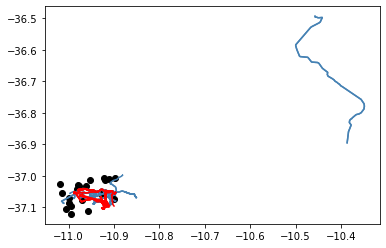

In [ ]:
a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

m = 20
Q = np.ones((m,2))

Q[:,0] = 0.2 * (b - a ) * np.random.random_sample(m) + a - 0.01
Q[:,1] = 0.2 *(d - c ) * np.random.random_sample(m) + c - 0.02

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");
plt.scatter(Q[:,0], Q[:,1], color = "black")
print(colored(f'Original car-bus', 'yellow'))
plt.show()

# Classifiers and get_mu function

In [ ]:
CC = [100, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clf = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

In [ ]:
def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

# Run time Analysis

## $v_Q$, $v_Q^{\varsigma}$, $v_Q^{\exp}$, endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification_runtime
from v_Q_mu_endpoints_classification_runtime import runTime

Saving v_Q_mu_endpoints_classification_runtime.py to v_Q_mu_endpoints_classification_runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
import timeit



def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


'''The following class includes 3 functions:
        1. According to v_Q classification (classification_v_Q() function)
            a) Average
            b) Average-Majority
        2. According to v_Q^mu classification (classification_v_Q_mu() function)
            a) Average
            b) Average-Majority
        3. Endpoint classification (endpoint_classification() function)
            a) Only average'''

class runTime():
    def __init__(self, data_1, data_2, Q_size, classifiers, std_coeff=1, version='unsigned', sigma=1):
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.classifiers = classifiers
        self.version = version
        self.sigma = sigma
        self.std_coeff = std_coeff

    
        
    '''mu calculator function'''
        
    def get_mu(self, data_1, data_2):
        a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
        b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
        return max(abs(a-b)) * self.std_coeff


    def generate_Q_runtime(self):

        start_time = time.time()
        data = np.concatenate((self.data_1, self.data_2), 0)

        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)

        Q = np.ones((self.Q_size, 2))
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

        stop_time = time.time()
        total_time = stop_time - start_time

        return total_time


    def train_classifier_v_Q_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = curve2vec(Q, data, version=self.version, sigma=self.sigma)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime


    def train_classifier_v_Q_exp_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            mu = self.get_mu(self.data_1, self.data_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = ExpCurve2Vec(Q, data, mu)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

    '''Get the endpoints of all trajectories in data_1 and data_2'''
    def get_endpoints(self):
        n_1 = len(self.data_1)
        n_2 = len(self.data_2)
        data_1_endpoints = np.zeros((n_1, 4))
        data_2_endpoints = np.zeros((n_2, 4))
        for i in range(n_1):
            data_1_endpoints[i] = np.concatenate((self.data_1[i][0], self.data_1[i][-1]), 0)
        for i in range(n_2):
            data_2_endpoints[i] = np.concatenate((self.data_2[i][0], self.data_2[i][-1]), 0)
        return data_1_endpoints, data_2_endpoints
        

    '''Get the endpoint classification error
       parameters: 
            1. data_1, data_2
            2. epoch
            3. classifiers'''
    def train_classifier_endpoint_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]
        r = len(self.classifiers)
        train_runtime = np.zeros(r)
        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 

        data_1_endpoints, data_2_endpoints = self.get_endpoints()
        Data = np.concatenate((data_1_endpoints, data_2_endpoints), 0)
        labels = np.array([1]*n_1 + [-1]*n_2)

        for k in range(r):
            time_temp = time.time()
            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time()
            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

## Runtime of initializing random landmarks with different classifiers

In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.generate_Q_runtime()
print(A)
print(colored(f'runtimes for generating random Q: {A}', 'yellow'))

The slowest run took 7.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 865 ns per loop
0.005908012390136719
runtimes for generating random Q: 0.005908012390136719


## Runtime of training classifiers

In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 8.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 931 ns per loop
run time: 0.5645260810852051
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.075171
2  Gaussian SVM, C=100, gamma=auto  0.071362
3  Poly kernel SVM, C=10, deg=auto  0.072181
4                    Decision Tree  0.067894
5     RandomForestClassifier, n=50  0.138942
6                              KNN  0.066300
7              Logistic Regression  0.072640
runtimes for v_Q: [0.07517051696777344, 0.07136178016662598, 0.07218146324157715, 0.06789374351501465, 0.13894176483154297, 0.0662999153137207, 0.07264018058776855]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='signed', sigma=1)
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='signed', sigma=1)
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^varsigma: {list(A[1])}', 'yellow'))

The slowest run took 7.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 972 ns per loop
run time: 1.1357877254486084
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.156448
2  Gaussian SVM, C=100, gamma=auto  0.154710
3  Poly kernel SVM, C=10, deg=auto  0.155463
4                    Decision Tree  0.155574
5     RandomForestClassifier, n=50  0.217628
6                              KNN  0.146808
7              Logistic Regression  0.149124
runtimes for v_Q^varsigma: [0.1564476490020752, 0.1547098159790039, 0.15546274185180664, 0.15557384490966797, 0.21762800216674805, 0.14680790901184082, 0.1491241455078125]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.train_classifier_v_Q_exp_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^exp: {list(A[1])}', 'yellow'))

The slowest run took 8.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 926 ns per loop
run time: 0.5967295169830322
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.076997
2  Gaussian SVM, C=100, gamma=auto  0.078820
3  Poly kernel SVM, C=10, deg=auto  0.076455
4                    Decision Tree  0.076720
5     RandomForestClassifier, n=50  0.143053
6                              KNN  0.071472
7              Logistic Regression  0.073178
runtimes for v_Q^exp: [0.07699728012084961, 0.07881975173950195, 0.07645487785339355, 0.07671999931335449, 0.1430530548095703, 0.07147216796875, 0.07317781448364258]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf)
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf)
A = Runtime.train_classifier_endpoint_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 10.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 881 ns per loop
run time: 0.08534502983093262
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.001128
2  Gaussian SVM, C=100, gamma=auto  0.001843
3  Poly kernel SVM, C=10, deg=auto  0.001349
4                    Decision Tree  0.000556
5     RandomForestClassifier, n=50  0.069502
6                              KNN  0.000421
7              Logistic Regression  0.009215
runtimes for v_Q: [0.0011284351348876953, 0.0018427371978759766, 0.0013494491577148438, 0.0005559921264648438, 0.06950187683105469, 0.0004210472106933594, 0.009215354919433594]


## Mistake-driven

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Runtime
from Perceptron_Like_Algo_Runtime import runTimeMD

Saving Perceptron_Like_Algo_Runtime.py to Perceptron_Like_Algo_Runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
from scipy.stats import entropy




def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


# models = ['LSVM', 'GSVM', 'PSVM', 'LR', 'PERN', 'DT', 'RF', 'KNN']

class runTimeMD:
    def __init__(self, data_1, data_2, Q_size, model, C, gamma, std_coeff, 
                 n_neighbors, n_estimators):
        
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.model = model
        self.C = C
        self.gamma = gamma
        self.std_coeff = std_coeff
        self.n_neighbors = n_neighbors
        self.n_estimators = n_estimators
        
        
    
        
    '''mu calculator function'''
        
    def get_mu(self):
        a = np.mean([np.mean(self.data_1[i], 0) for i in range(len(self.data_1))], 0)
        b = np.mean([np.mean(self.data_2[i], 0) for i in range(len(self.data_2))], 0)
        return max(abs(a-b)) * self.std_coeff
       
        
    '''Perceptron-Like Algorithm'''
        
    def initialize_Q(self): 
        
        Q = []        

        mu = self.get_mu()
        std = mu * self.std_coeff

        trajectory_train_data = np.concatenate((self.data_1, self.data_2), axis = 0)
        train_labels = np.concatenate(([1] * len(self.data_1), [-1] * len(self.data_2)), 0)
        index = np.random.randint(0, high=len(trajectory_train_data)) 
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)
        
        if self.model == "LSVM":
            clf = make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                        class_weight='balanced', max_iter=1000))
        elif self.model == "GSVM":
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                gamma=self.gamma, max_iter=200000))
        elif self.model == 'PSVM':
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                    degree=3, max_iter = 400000))
        elif self.model == "LR":
            clf = LogisticRegression(solver='lbfgs')
        elif self.model == "Prn":
            clf = Perceptron(tol=1e-5, validation_fraction=0.01, class_weight="balanced")
        elif self.model == "DT":
            clf = DecisionTreeClassifier()
        elif self.model == "RF":
            clf = RandomForestClassifier(n_estimators=self.n_estimators)
        elif self.model == "KNN":
            clf = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        else:
            print("error: model is not supported")
        
        for i in range(self.Q_size):
            train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
            clf.fit(train_data, train_labels)

            train_pred = clf.predict(train_data)
            error = sum(train_labels != train_pred)/len(train_labels)
            
            if self.model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
                temp = train_labels * clf.decision_function(train_data)
                index = np.argmin(temp)
            elif self.model in ['DT', 'RF', 'KNN']:
                probs = clf.predict_proba(train_data)
                index = np.argmax(entropy(probs, axis=1))
            
            k = np.random.randint(0, high=len(trajectory_train_data[index]))
            q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
            Q.append(q)
        
        return np.array(Q), mu



    
    def train_classifier_runtime_Q(self):

        if self.model == 'LSVM':
            clf_L = [make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                       class_weight ='balanced', max_iter=1000)), 
                    "SVM, Linear SVC, C="+str(self.C)]
            clf = clf_L[0] 
        elif self.model == 'GSVM':
            clf_rbf = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                    gamma=self.gamma, max_iter=200000)), 
                       "GSVM, C="+str(self.C)+", gamma="+str(self.gamma)]
            clf = clf_rbf[0]
        elif self.model == 'PSVM':
            clf_PSVM = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                        degree=3, max_iter = 400000)),
                        "Poly kernel SVM, C="+str(self.C)+", deg=auto"]
            clf = clf_PSVM[0]
        elif self.model == "LR":
            clf_LR = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]
            clf = clf_LR[0]
        elif self.model == "Prn":
            clf_Prn = [Perceptron(tol=1e-5, validation_fraction=0.01, 
                               class_weight="balanced"), "Perceptron"]
            clf = clf_Prn [0]
        elif self.model == "DT":
            clf_DT = [DecisionTreeClassifier(), "Decision Tree"]
            clf = clf_DT[0]
        elif self.model == "RF":
            clf_RF = [RandomForestClassifier(n_estimators=self.n_estimators), 
                             "RandomForestClassifier, n="+str(self.n_estimators)]
            clf = clf_RF[0]
        elif self.model == "KNN":
            clf_KNN = [KNeighborsClassifier(n_neighbors=self.n_neighbors), "KNN"]
            clf = clf_KNN[0]
        else:
            print('model is not supported')

        start_time = time.time()

        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 
        data = np.concatenate((self.data_1, self.data_2), axis = 0)
        labels = np.array([1]*n_1 + [-1]*n_2)
        
        I = np.arange(len(data))
        np.random.shuffle(I)
        data = data[I]
        labels = labels[I]

        init_Q_strat_time = time.time()
        B = self.initialize_Q()
        init_Q_end_time = time.time()
        init_total_time = init_Q_end_time - init_Q_strat_time
        
        Q = B[0]
        mu = B[1]
        Data = ExpCurve2Vec(Q, data, mu)
        clf.fit(Data, labels)

        train_runtime = time.time() - start_time

        return train_runtime, init_total_time


## Runtime of training classifiers

In [ ]:
model = 'LSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.80 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.21 µs per loop
runtimes for initializing 20 landmarks with LSVM: 1.2072
runtimes for LSVM: 1.2842


In [ ]:
model = 'GSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.76 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with GSVM: 1.2567
runtimes for GSVM: 1.3335


In [ ]:
model = 'PSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


runtimes for initializing 20 landmarks with PSVM: 1.5273
runtimes for PSVM: 1.6011


In [ ]:
model = 'DT'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 8.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with DT: 1.2087
runtimes for DT: 1.2819


In [ ]:
model = 'RF'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 9.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with RF: 2.9791
runtimes for RF: 3.1383


In [ ]:
model = 'KNN'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.35 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with KNN: 1.317
runtimes for KNN: 1.3901


In [ ]:
model = 'LR'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.21 µs per loop
runtimes for initializing 20 landmarks with LR: 1.2923
runtimes for LR: 1.3729


## KNN runtime

### install package

In [ ]:
# to make a directory
%cd 'gdrive/My Drive/traj-dist'

/content/gdrive/My Drive/traj-dist


In [ ]:
# to see in what directory we are in

In [ ]:
pwd

'/content/gdrive/My Drive/traj-dist'

In [ ]:
# to install setup.py from the current directory
!python setup.py install

In [ ]:
!pip install geohash2

In [ ]:
pip install fastdtw

In [ ]:
pip install tslearn

### KNN runtimes

In [ ]:
from google.colab import files
files.upload()

import KNN_Class_Colab_runtime
from KNN_Class_Colab_runtime import KNN_runTime

Saving KNN_Class_Colab_runtime.py to KNN_Class_Colab_runtime (1).py


In [ ]:
'''This class handles all the metrics in "metrics array bellow" and is appropriate for using in Anaconda 
   for example, but not on Google Colab.'''

'''Requirements: (These are already installed in my computer)
        1. We need "pip install trjtrypy" in order to be able to use d_Q_pi
        2. We need "pip install tslearn" in order to be able to use dtw
        3. We need "pip install fastdtw" in order to be able to use fastdtw
        4. We need "pip install traj_dist" in order to be able to use the rest of metrics'''


import numpy as np
import time
import pandas as pd
import random
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from termcolor import colored

#metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss',  
#           fastdtw, dtw, d_Q_pi]

# path example: 
#'Calculated Distance Matrices for KNN/Beijing-Pairs['+str(pairs_final[i])+']-d_Q_pi.csv'


class KNN_runTime:
    
    def __init__(self, data1, data2, metric, gamma=None, eps_edr=None, eps_lcss=None, 
                 Q_size=None, Q=None, p=2, n_neighbors=5, pair=None):
        '''data1 = data[pair[0]]
           data2 = data[pair[1]]'''
        self.data1 = data1
        self.data2 = data2
        self.metric = metric
        self.gamma = gamma
        self.eps_edr = eps_edr
        self.eps_lcss = eps_lcss
        self.Q_size = Q_size
        self.Q = Q
        self.p = p
        self.n_neighbors = n_neighbors
        self.pair = pair
    



    def calculate_dists_matrix(self):

        data = np.concatenate((self.data1, self.data2), 0)
        n = len(data)

        if self.metric == 'lcss':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_lcss)
        if self.metric == 'edr':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_edr)
        if self.metric in ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp']: 
            A = tdist.pdist(data, str(self.metric))
        if self.metric == fastdtw: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j])[0])
        if self.metric == dtw_tslearn: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j]))
        if self.metric == 'd_Q_pi':
            A = []
            if self.Q_size:
                Q = self.generate_random_Q()
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(Q, data[i], data[j], p=self.p))
            elif len(self.Q):
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(self.Q, data[i], data[j], p=self.p))

        tri = np.zeros((n, n))
        tri[np.triu_indices(n, 1)] = np.array(A)
        for i in range(1, n):
            for j in range(i):
                tri[i][j] = tri[j][i]
                
        return tri





    '''The following function is only used for d_Q_pi distance in order to 
       generate random landmarks
       Notice: in this pattern of coding we cannot use train1 and train2 to 
       get Q in the following function.'''
    def generate_random_Q(self):
        Q = np.zeros((self.Q_size, 2))
        data = np.concatenate((self.data1, self.data2), 0)
        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)
        return Q




    def KNN_runtime(self):
        
        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2) 
        
        labels = np.array([1] * n_1 + [-1] * n_2)
        data = np.concatenate((self.data1, self.data2), 0)
        dist_matrix = self.calculate_dists_matrix()

        clf = KNeighborsClassifier(n_neighbors=self.n_neighbors, metric='precomputed')
        clf.fit(dist_matrix, list(labels))
        stop_time = time.time()
        runtime = stop_time - start_time

        return runtime
    

In [ ]:
metrics = ['discret_frechet', 'hausdorff', dtw_tslearn, fastdtw, 'lcss', 'sspd',
           'edr', 'erp', 'd_Q_pi']
runtimes = []
for metric in metrics:
    %timeit KNN_runTime(cars, buses, metric=metric, gamma=None, eps_edr=0.02, \
                        eps_lcss=0.02, Q_size=20, Q=None, p=2, n_neighbors=5, pair=[0,1])

    Runtime = KNN_runTime(cars, buses, metric=metric, gamma=None, eps_edr=0.02, 
                      eps_lcss=0.02, Q_size=20, Q=None, p=2, n_neighbors=5, pair=[0,1])
    a = Runtime.KNN_runtime()
    runtimes.append(a)
    print(colored(f'runtimes for {metric}: {a}', 'yellow'))
    print(colored("===============================================================", 'red'))

print(colored(runtimes, 'blue'))

The slowest run took 10.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.46 µs per loop
runtimes for discret_frechet: 13.888860702514648
The slowest run took 5.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.46 µs per loop
runtimes for hausdorff: 7.758051633834839
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.48 µs per loop
runtimes for <function dtw at 0x7f115f76b5f0>: 6.160368919372559
The slowest run took 5.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.49 µs per loop
runtimes for <built-in function fastdtw>: 1.5054645538330078
The slowest run took 5.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best 

/usr/local/lib/python3.7/dist-packages/traj_dist-1.1-py3.7-linux-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


runtimes for erp: 45.32779359817505
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.45 µs per loop
runtimes for d_Q_pi: 10.646199941635132
[13.888860702514648, 7.758051633834839, 6.160368919372559, 1.5054645538330078, 14.494276523590088, 7.809615850448608, 15.586239337921143, 45.32779359817505, 10.646199941635132]


### KNN_LSH

In [ ]:
from google.colab import files
files.upload()

import KNN_with_LSH_runtime
from KNN_with_LSH_runtime import KNN_LSH_runTime

Saving KNN_with_LSH_runtime.py to KNN_with_LSH_runtime (1).py


In [ ]:
# pip install trjtrypy

'''A clss for KNN with LSH distance with random circles in each iteration'''

import numpy as np 
import time
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.basedists import distance
from termcolor import colored




class KNN_LSH_runTime:
    def __init__(self, data1, data2, number_circles):
        self.data1 = data1
        self.data2 = data2
        self.number_circles = number_circles



    def get_circles(self):

        data = np.concatenate((self.data1, self.data2,), 0)
        n = len(data)
        Mean = np.mean([np.mean(data[i], 0) for i in range(n)], 0)
        Std = np.std([np.std(data[i], 0) for i in range(n)], 0)
        circles_centers = np.ones((self.number_circles,2))
        circles_centers[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.number_circles)
        circles_centers[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.number_circles)

        return circles_centers



    def get_radius(self):

        a = np.mean([np.mean(self.data1[i], 0) for i in range(len(self.data1))], 0)
        b = np.mean([np.mean(self.data2[i], 0) for i in range(len(self.data2))], 0)

        return max(abs(a-b))



    def LSH_sketch(self):

        radius = self.get_radius()
        #print("radius =", radius)
        data = np.concatenate((self.data1, self.data2), 0)
        circles_centers = self.get_circles()
        dists = distance(circles_centers, data) # shape = len(data) x number_circles
        LSH_array = np.zeros((len(data), self.number_circles))
        circules_cut_idx = np.where(dists < radius)
        LSH_array[circules_cut_idx] = 1

        return LSH_array


    def calculate_LSH_dists(self):

        LSH_array = self.LSH_sketch()
        data = np.concatenate((self.data1, self.data2), 0)
        dists = np.zeros((len(data), len(data)))
        for i in range(len(data)-1):
            dists[i, i+1:] = np.sum(abs(LSH_array[i+1:] - LSH_array[i]), 1)
        for i in range(len(data)-1):
            for j in range(i+1, len(data)):
                dists[j][i] = dists[i][j]
        
        return dists



    def KNN_LSH_runtime(self):

        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2)

        radius = self.get_radius()
        dist_matrix = self.calculate_LSH_dists()

        labels = np.array([1]*n_1 + [-1] * n_2)

        clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        clf.fit(dist_matrix, list(labels))

        stop_time = time.time()
        runtime = stop_time - start_time
        
        return runtime


In [ ]:
%timeit KNN_LSH = KNN_LSH_runTime(cars, buses, number_circles=20)

KNN_LSH = KNN_LSH_runTime(cars, buses, number_circles=20)
t = KNN_LSH.KNN_LSH_runtime()
print(colored(f'runtime for KNN with LSH is: {t}', 'yellow'))

The slowest run took 12.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 573 ns per loop
runtime for KNN with LSH is: 0.08276605606079102
